# PyTorch Deep Explainer DeepSEA example

Running the pytorch Deep Explainer on the DeepSEA model from the kipoi repo

First, we pull the kipoi pytorch model and load it up

In [1]:
import torch

#pull the model from kipoi
! [[ -f deepsea_model_architecture.py ]] || wget https://raw.githubusercontent.com/kipoi/models/master/DeepSEA/model_architecture.py -O deepsea_model_architecture.py
! [[ -f deepsea_model_weights.pth ]] || wget https://zenodo.org/record/1466993/files/deepsea_variant_effects.pth?download=1 -O deepsea_model_weights.pth
from deepsea_model_architecture import veff_model as pytorch_model, Lambda
pytorch_model.load_state_dict(torch.load("deepsea_model_weights.pth"))
pytorch_model = pytorch_model.eval()

Create the model to be interpreted; note that to avoid artifacts caused by the saturating nature of sigmoids (as explained in the DeepLIFT paper), we do the explanation w.r.t. the linear portion prior to the final sigmoidal nonlinearity.

In [2]:
import torch.nn as nn

def gather_list_of_layers(module):
    layers_list = []
    for child in module.children():
        if 'nn.modules.container' in str(type(child)):
            layers_list.extend(gather_list_of_layers(child))
        else:
            layers_list.append(child)
    return layers_list


def create_interpretation_model(original_model, idx_to_select, prenonlinearity):
    all_layers = gather_list_of_layers(original_model)
    if (prenonlinearity):
        all_layers = all_layers[:-1]
    all_layers.append(Lambda(lambda x: x[:,idx_to_select:(idx_to_select+1)]))
    interpretation_model = nn.Sequential(*all_layers)
    return interpretation_model

#model for getting importance scores for task index 65
interpretation_model = create_interpretation_model(pytorch_model,65, prenonlinearity=True)

Prepare some one-hot encoded example sequences to be interpreted

In [3]:
example_sequences = [
    "GGCGATCCTTAGGCCTTGGCCCTGAGACCCCAGGCGAGGTCAGCAACCCAACCG"
    "GGGTGGGACAGGACGAGCAAGAGGTTCTGCTCACGCATGTCCCCACTAACCTGG"
    "CCGAGGGGCTCCCGCCCGGCTTATCCGGACTCCGGGCAGCCTCGCGTGCTTCCC"
    "GTGTCTCCGCTTGTGGAGAATTTTCGGACTCGGATTCGGACTCGGAGTCAAAGC"
    "CCGAAGCTAGGAACTCGTCCACCGTCAGCTCCGCCAGGCGCCTGCGGGTCACGC"
    "AGGAGTCACAGCTGCCCGCACGCCCAGCTCGCCCCAGCCCCGCTGAGAGGAGCA"
    "AGAAAAGCCCCCTTGGATACAGACACCCACCGGGAGGCCAAATCGGCCCTCGGA"
    "CCCGCGGCTTACCTCTTGCGGCTCCCCGCAGCTGCCATGACACCAACCCGAAGC"
    "GTGCACCCCACTTCCGGCCCCAGAATGCCGCGCGGCTGCGCACTTCCGccgccc"
    "aggccccgcccctttccccgccccgccgcgccacgcccagccGAGTGGCTCTAT"
    "GGTTCTCCGACCGCAACGCCGGCGGCCTCAGGGCGGGAGGGCGCGTTCGCGTGC"
    "TCGGTGCGGGCAGCCCCGGTGGGGCCCAGATGCGCCTCCCGCTCGGCGCCCGGC"
    "TCCGTAGGACGCGGTGACGCCGGTGTCCGCCCCGGGGAAGACCGGGAGTCCCGC"
    "CGCGCCCGCAGCCCACCCGGCGCTCCGAAGGCACGCGCCTGCGAGGACGCCAGA"
    "CTGCAACGGCGGGGCTCCTATGCAAAGAGCTCCCACAAATCAACAATAAAAAGC"
    "AGGGAGTCCAGTGGAAAACGCGAGGGGCAGTGGGAACCGCACTGATGTCGCCAG"
    "CTCGACAAAAGACGGGCGACCCGAGGGCCAGGCTGGCTTCGCCTCCGATCCGCG"
    "GAGACCGGGCCAGCGCCACGAACACCACGCAGGGCGCTCCCCGTCCATGGCCCT"
    "CTGGGTGCCGACCGCGGCTCTTCCCGGG",
    "GGGCTGAGGGTGGCCGGGCGGCTGCACACTAGCTGGGTCGCGGCGCAGAAACGC"
    "AGGGGCCGCGAGTGCGCTGGCCGGCGGGTGTCCCGGGTCCACGCTTACGGTCCT"
    "CATGTTCTTTTTCTTCAGGTATCGGGCTTTGGTGCATTTCACAAAGGCTCGAAT"
    "CACGGTTCTGACCGCCAACCTGTAGCAGCGATTTTTCCTTCCCCGGAAGTGCTG"
    "GGACAGAAAACGAGAAACCAGGGTTGTCAgcggggcccgcgccggccgccccTT"
    "GGCCCGCGGGATACCCCGGGCGCCCAGTGCCCAGGCCGGGCAGGCGGCACTCAC"
    "CCTGGCGTGCTTCAGCACCTCCTGGATCCGAAAGTAGCGGTCGGTGACGCGATT"
    "CCGCAGCCAGAGCTGCGCGGTGAGGAAGACCATGGCGCCTGCAGGCCGGCGTCC"
    "CGAACACTCAACAACGCACGCGCAGCGCCGCTGCCATCTTGCCCGGGTCGGAAA"
    "TGGTGGTCACGAGCGCTTCCGGGTCAGCCCCTGCGATACTTCCGGGGCGAAGGT"
    "CGTCTCCCGTCAGCCCGCGGGTGCCCAGTTGTGCTCCTGAACTCGCGGTGGTGG"
    "TGCGTGTTGGGGAGCGGATGTGGGGCCGCGGCGGGGACTGAAAGGAGAACGGGG"
    "CCGCAGCGCCCGTGGCTATTCGCGGACGATGGATAAACAGCAGCGCACGCGGAC"
    "CGTCCCGGAGCACGGCCCCGGCCGCAGCTGTGGCTCCGAGGGCACCGTGAGGGC"
    "AGCGGACCCGGGTcgggggccccgcggccggggagctcgggtgcggcgcgggcg"
    "gggaggggcaggccgcccccTGGGGCCACGAGGATGTTCAGGAACCGAGGTGGA"
    "GATGGTCGCATCGGTGTGAAAGTGCCCGTTGCCTCTGAACCTTGCACtttgttt"
    "acttactcattttgagacggggtctcgcccggtcgccctggctggggtgcagcg"
    "gcccgacctcggctcgccgcggcctctg"
]   

#code for one-hot encoding
import numpy as np
import torch


#this is set up for 1d convolutions where examples
#have dimensions (len, num_channels)
#the channel axis is the axis for one-hot encoding.
def one_hot_encode_along_channel_axis(sequence):
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return.transpose((1,0))[:,None,:]


def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1

            
onehot_data = np.array([one_hot_encode_along_channel_axis(seq) for seq in example_sequences])

Get the explanations

Sequence idx 0
Actual contributions


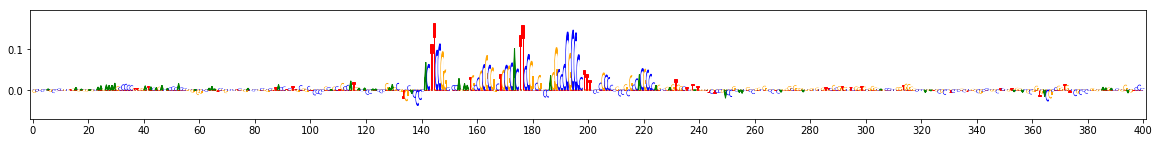

Hypothetical contributions


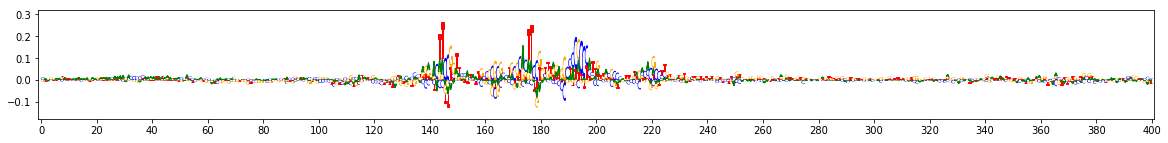

Sequence idx 1
Actual contributions


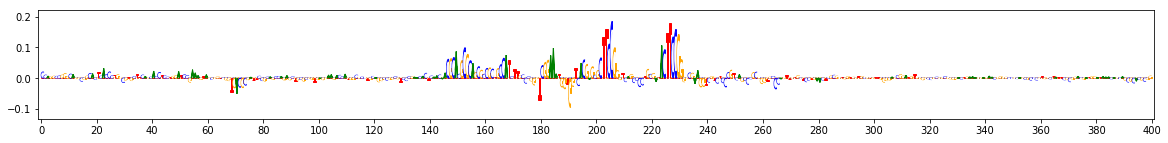

Hypothetical contributions


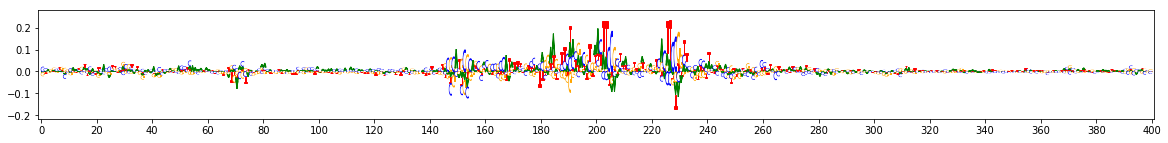

In [4]:
!pip install deeplift

%matplotlib inline
from deeplift.dinuc_shuffle import dinuc_shuffle, traverse_edges, shuffle_edges, prepare_edges
from deeplift.visualization import viz_sequence
from collections import Counter
import numpy as np
import shap
import importlib
from importlib import reload
reload(shap.explainers.deep)
reload(shap.explainers.deep.deep_pytorch)
reload(shap.explainers)
reload(shap)
import torch

#this function performs a dinucleotide shuffle of a one-hot encoded sequence
#It expects the supplied input in the format (length x 4)
def onehot_dinuc_shuffle(s):
    s = np.squeeze(s)
    assert len(s.shape)==2
    assert s.shape[1]==4
    argmax_vals = "".join([str(x) for x in np.argmax(s, axis=-1)])
    shuffled_argmax_vals = [int(x) for x in traverse_edges(argmax_vals,                          
                            shuffle_edges(prepare_edges(argmax_vals)))]
    to_return = np.zeros_like(s)    
    to_return[list(range(len(s))), shuffled_argmax_vals] = 1
    return to_return

#This generates 100 dinuc-shuffled references per sequence
#In my (Avanti Shrikumar) experience,
# 100 references per sequence is on the high side; around 10 work well in practice
# I am using 100 references here just for demonstration purposes.
#Note that when an input of None is supplied, the function returns a tensor
# that has the same dimensions as actual input batches
def shuffle_several_times(inp):
    #I am assuming len(inp) == 1 because this function is designed for models with one
    # input mode (i.e. just sequence as the input mode)
    assert (inp is None) or len(inp)==1
    if (inp is None):
        return torch.tensor(np.zeros((1,4,1,1000)).astype("float32"))
    else:
        #Some reshaping/transposing needs to be performed before calling
        # onehot_dinuc_shuffle becuase the input to the DeepSEA model
        # is in the format (4 x 1 x length) for each sequence, whereas
        # onehot_dinuc_shuffle expects (length x 4)
        to_return = torch.tensor(np.array([
            onehot_dinuc_shuffle(
                inp[0].detach().cpu().numpy().squeeze().transpose(1,0)).transpose((1,0))[:,None,:]
            for i in range(100)]).astype("float32"))
        return to_return
    
#This combine_mult_and_diffref function can be used to generate hypothetical
# importance scores for one-hot encoded sequence.
#Hypothetical scores can be thought of as quick estimates of what the
# contribution *would have been* if a different base were present. Hypothetical
# scores are used as input to the importance score clustering algorithm
# TF-MoDISco (https://github.com/kundajelab/tfmodisco)
# Hypothetical importance scores are discussed more in this pull request:
#  https://github.com/kundajelab/deeplift/pull/36
def combine_mult_and_diffref(mult, orig_inp, bg_data):
    to_return = []
    #Perform some reshaping/transposing because the code was designed
    # for inputs that are in the format (length x 4), whereas the DeepSEA
    # model has inputs in the format (4 x 1 x length)
    mult = [x.squeeze().transpose((0,2,1)) for x in mult]
    orig_inp = [x.squeeze().transpose((1,0)) for x in orig_inp]
    bg_data = [x.squeeze().transpose((0,2,1)) for x in bg_data]
    for l in range(len(mult)):
        #At each position in the input sequence, we iterate over the one-hot encoding
        # possibilities (eg: for genomic sequence, this is ACGT i.e.
        # 1000, 0100, 0010 and 0001) and compute the hypothetical 
        # difference-from-reference in each case. We then multiply the hypothetical
        # differences-from-reference with the multipliers to get the hypothetical contributions.
        #For each of the one-hot encoding possibilities,
        # the hypothetical contributions are then summed across the ACGT axis to estimate
        # the total hypothetical contribution of each position. This per-position hypothetical
        # contribution is then assigned ("projected") onto whichever base was present in the
        # hypothetical sequence.
        #The reason this is a fast estimate of what the importance scores *would* look
        # like if different bases were present in the underlying sequence is that
        # the multipliers are computed once using the original sequence, and are not
        # computed again for each hypothetical sequence.
        projected_hypothetical_contribs = np.zeros_like(bg_data[l]).astype("float")
        assert len(orig_inp[l].shape)==2, orig_inp[l].shape
        for i in range(orig_inp[l].shape[-1]):
            hypothetical_input = np.zeros_like(orig_inp[l]).astype("float")
            hypothetical_input[:,i] = 1.0
            hypothetical_difference_from_reference = (hypothetical_input[None,:,:]-bg_data[l])
            hypothetical_contribs = hypothetical_difference_from_reference*mult[l]
            projected_hypothetical_contribs[:,:,i] = np.sum(hypothetical_contribs,axis=-1) 
        to_return.append(np.mean(projected_hypothetical_contribs,axis=0).transpose((1,0))[:,None,:])
    return to_return

#Instantiate the explainer. shuffle_several_times is the function that
# will be used to generate references for each sequence.
#combine_mult_and_diffref is the function that will be used to generate
# the hypothetical scores using the multipliers and difference-from-reference values.
e = shap.DeepExplainer(interpretation_model, shuffle_several_times,
                       combine_mult_and_diffref=combine_mult_and_diffref)
shap_explanations = e.shap_values(torch.tensor(onehot_data.astype("float32")))

#visualize the importance scores
for idx, (hypimpscores,orig_seq) in enumerate(zip(shap_explanations,onehot_data)):
    print("Sequence idx",idx)
    print("Actual contributions")
    # (The actual importance scores can be computed using an element-wise product of
    #  the hypothetical importance scores and the actual importance scores)
    #For speed, I am only visualizing the scores in the central 400bp
    viz_sequence.plot_weights(hypimpscores[:,:,300:700]*orig_seq[:,:,300:700], subticks_frequency=20)
    print("Hypothetical contributions")
    viz_sequence.plot_weights(hypimpscores[:,:,300:700], subticks_frequency=20)
